In [1]:
import os
import numpy as np

# 일관된 출력을 위해 유사난수 초기화
np.random.seed(42)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
sn.set()

### 한글 깨짐 설정
import platform
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if( platform.system() =='Darwin' ):
    rc( 'font', family='AppleGothic' )
elif( platform.system() == 'Windows'):
    path='c:/Windows/Fonts/malgun.ttf'
    font_name= font_manager.FontProperties( fname=path ).get_name()
    rc('font',family=font_name)
else:
    print('error')

### 5.1 선형 SVM 분류

- 라진 마진 분류
    - 두 데이터의 클래스를 분리할 수 있는 무수히 많은 직선들 중 두 데이터 클래스간의 간격(margin)이 최대로하는 **MMH**(Maximum Marginal Hyperplane, 최대 마진 초평면)을 찾아 분리하는 방법
    
##### 5.1.1 소프트 마진 분류

- 하드 마진 분류
    - **매우 엄격하게** 두 개의 클래스를 분리하는 방법
    - 문제점
        - **선형적**으로 구분될 수 있을때 제대로 작동
        - **이상치**에 민감

In [2]:
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

# SVM 분류 모델
svm_clf = SVC(kernel="linear", C=float("inf"))
svm_clf.fit(X, y)

SVC(C=inf, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [3]:
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # 결정 경계에서 w0*x0 + w1*x1 + b = 0 이므로
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_  # support vectors
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

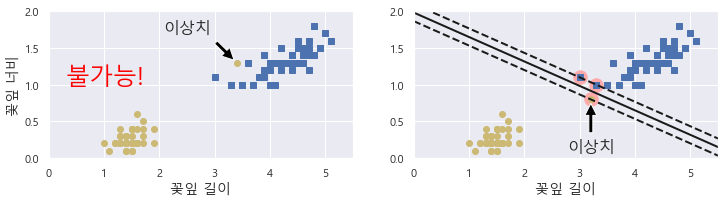

In [4]:
X_outliers = np.array([[3.4, 1.3], [3.2, 0.8]])
y_outliers = np.array([0, 0])
Xo1 = np.concatenate([X, X_outliers[:1]], axis=0)
yo1 = np.concatenate([y, y_outliers[:1]], axis=0)
Xo2 = np.concatenate([X, X_outliers[1:]], axis=0)
yo2 = np.concatenate([y, y_outliers[1:]], axis=0)

svm_clf2 = SVC(kernel="linear", C=10**9)
svm_clf2.fit(Xo2, yo2)

plt.figure(figsize=(12,2.7))

plt.subplot(121)
plt.plot(Xo1[:, 0][yo1==1], Xo1[:, 1][yo1==1], "bs")
plt.plot(Xo1[:, 0][yo1==0], Xo1[:, 1][yo1==0], "yo")
plt.text(0.3, 1.0, "불가능!", fontsize=24, color="red")
plt.xlabel("꽃잎 길이", fontsize=14)
plt.ylabel("꽃잎 너비", fontsize=14)
plt.annotate("이상치",
             xy=(X_outliers[0][0], X_outliers[0][1]),
             xytext=(2.5, 1.7),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

plt.subplot(122)
plt.plot(Xo2[:, 0][yo2==1], Xo2[:, 1][yo2==1], "bs")
plt.plot(Xo2[:, 0][yo2==0], Xo2[:, 1][yo2==0], "yo")
plot_svc_decision_boundary(svm_clf2, 0, 5.5)
plt.xlabel("꽃잎 길이", fontsize=14)
plt.annotate("이상치",
             xy=(X_outliers[1][0], X_outliers[1][1]),
             xytext=(3.2, 0.08),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

plt.show()

위와 같은 문제를 해결하기 위해, **소프트 마진**(Soft Margin) SVM이 개발.

소프트 마진 SVM은 기본적으로 하드 마진 방법을 기반으로 하는데, 가장 큰 차이점은 Support Vectors가 위치한 경계선에 약간의 **여유 변수**(Slack Variable)을 두는 것이다.

Scikit-Learn의 SVM 모델에서는 이러한 여유 변수를 `C`라는 하이퍼파라미터를 제공한다. `C`는 일종의 **penalty**라고 볼 수 있다.

- `C` 값을 줄이면 오류를 허용하는 정도가 커지며, Margin 또한 커진다.
- `C` 값을 크게하면 오류를 허용하는 정도가 작아지며, Margin 또한 작아진다.

In [5]:
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
X = iris['data'][:, (2, 3)]  # petal lenght, petal width
y = (iris['target'] == 2).astype(np.float64)  # Iris - Virginca면 1 아니면 0

svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('liear_svc', LinearSVC(C=1, loss='hinge', random_state=42))
])

svm_clf.fit(X, y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('liear_svc',
                 LinearSVC(C=1, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='hinge', max_iter=1000, multi_class='ovr',
                           penalty='l2', random_state=42, tol=0.0001,
                           verbose=0))],
         verbose=False)

In [6]:
scaler = StandardScaler()
svm_clf1 = LinearSVC(C=1, loss="hinge", random_state=42)
svm_clf2 = LinearSVC(C=100, loss="hinge", random_state=42)

scaled_svm_clf1 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf1),
    ])
scaled_svm_clf2 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf2),
    ])

scaled_svm_clf1.fit(X, y)
scaled_svm_clf2.fit(X, y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linear_svc',
                 LinearSVC(C=100, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='hinge', max_iter=1000, multi_class='ovr',
                           penalty='l2', random_state=42, tol=0.0001,
                           verbose=0))],
         verbose=False)

In [7]:
# 스케일되지 않은 파라미터로 변경
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_
svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

# 서포트 벡터 찾기 (libsvm과 달리 liblinear 라이브러리에서 제공하지 않기 때문에 
# LinearSVC에는 서포트 벡터가 저장되어 있지 않습니다.)
t = y * 2 - 1
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()
svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx2]

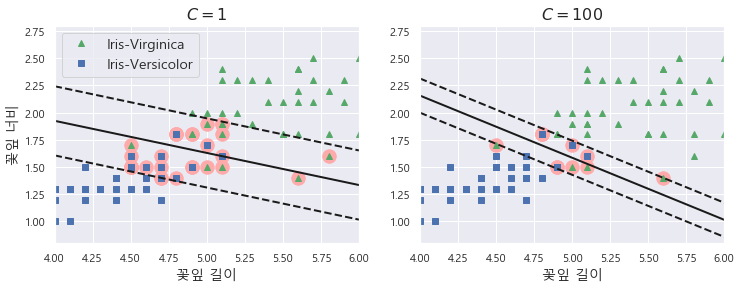

In [8]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris-Virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris-Versicolor")
plot_svc_decision_boundary(svm_clf1, 4, 6)
plt.xlabel("꽃잎 길이", fontsize=14)
plt.ylabel("꽃잎 너비", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title("$C = {}$".format(svm_clf1.C), fontsize=16)
plt.axis([4, 6, 0.8, 2.8])

plt.subplot(122)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 6)
plt.xlabel("꽃잎 길이", fontsize=14)
plt.title("$C = {}$".format(svm_clf2.C), fontsize=16)
plt.axis([4, 6, 0.8, 2.8]);

### 5.2 비선형 SVM 분류

실제 데이터셋은 위에서 살펴본 Linear SVM으로 분류할 수 없는 즉, 선형적으로 분류할 수 없는 비선형 적인 데이터셋이 많다. 

이러한, 비선형 데이터셋을 다루는 한 가지 방법은 다항 특성(polynomial features)과 같은 특성을 추가하는 방법이 있다.

##### 5.2.1 다항식 커널

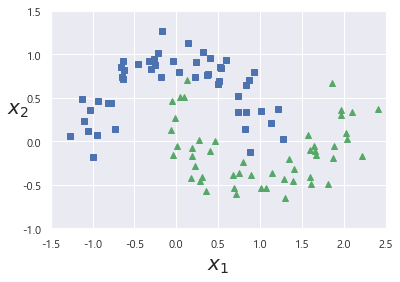

In [9]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

In [10]:
from sklearn.preprocessing import PolynomialFeatures

polynomial_svm_clf = Pipeline([
    ('poly_features', PolynomialFeatures(degree=3)),
    ('scaler', StandardScaler()),
    ('svm_clf', LinearSVC(C=10, loss='hinge', random_state=42))
])

polynomial_svm_clf.fit(X, y)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(memory=None,
         steps=[('poly_features',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 LinearSVC(C=10, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='hinge', max_iter=1000, multi_class='ovr',
                           penalty='l2', random_state=42, tol=0.0001,
                           verbose=0))],
         verbose=False)

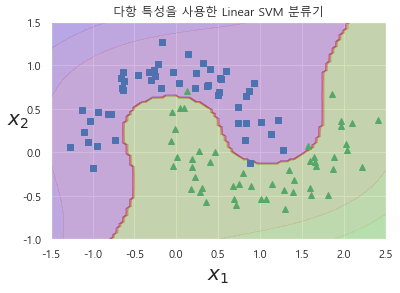

In [11]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title('다항 특성을 사용한 Linear SVM 분류기')
plt.show()

##### 5.2.2 유사도 특성 추가

비선형 특성을 다루는 또 다른 방법은 각 데이터(샘플)이 특정 **랜드마크**(landmark)와 얼마나 닮았는지 측정하는 **유사도 함수**(similarity function)로 계산한 특성을 추가하는 것이다. 

예를 들어, 아래의 그래프와 같이 $x_2 = -2$와 $x_3 = 1$을 랜드마크라고 하고, $\gamma = 0.3$인 가우시안 **RBF**(Radial Basis Function, 방사 기저 함수)를 유사도 함수라고 정의해보자.

$$
\phi_{\gamma} \left( \mathbf{x}, \ell \right) = \text{exp} \left( -\gamma \left\| \mathbf{x} - \ell \right\|^{2} \right)
$$

예를 들어, $x_1 = -1$일 경우 

- 첫 번째 랜드마크인 $x_1 = -2$에서 $\| -1 - (-2) \| = 1$ 
- 두 번째 랜드마크인 $x_2 = 1$에서 $2$

만큼 떨어져 있다.

따라서, $x_1$의 새로운 특성은 $x_2 = \text{exp}(-0.3 \times 1^2) \approx 0.74$ 와 $x_3 = \text{exp}(-0.3 \times 2^2) \approx 0.30$이다. 

이러한, 유사도 특성 추가를 통해 아래의 오른쪽 그래프와 같이 선형분리가 가능하다.

##### ??? 단점은 훈련세트에 있는 n개의 특성을 가진 m개의 샘플이 m개의 특성을 가진 m개의 샘플이 된다는 것 입니다. 훈련 세트가 매우 클 경우 동일한 크기의 매우 많은 특성이 만들어집니다. 

##### 5.2.3 가우시안 RBF 커널

유사도 특성을 추가하는 방법도 유용하게 사용될 수 있다. 하지만, 이러한 특성을 추가하기 위해서는 **계산 비용이 많이 드는 문제**가 있다. 

이를 가우시안 **RBF Kernel**을 이용하면 위와 같이 특성들을 계산하지 않고 비슷한 결과를 얻을 수 있다.

$$
K \left( \mathbf{a}, \mathbf{b} \right) = \text{exp} \left( -\gamma \left\| \mathbf{a} - \mathbf{b} \right\|^{2} \right)
$$

- $\gamma$ : regularization 역할을 함
    - $\gamma$가 커지면 종 모양이 좁아져 각 데이터의 영향 범위가 작아져, 결정 경계(Decision Boundary)가 불규칙하고 구부러진다.
    - $\gamma$가 작아지면 넓은 종 모양이 되며, 데이터의 영향이 넓어져 결정 경계가 부드러워 진다. 
    
##### C??

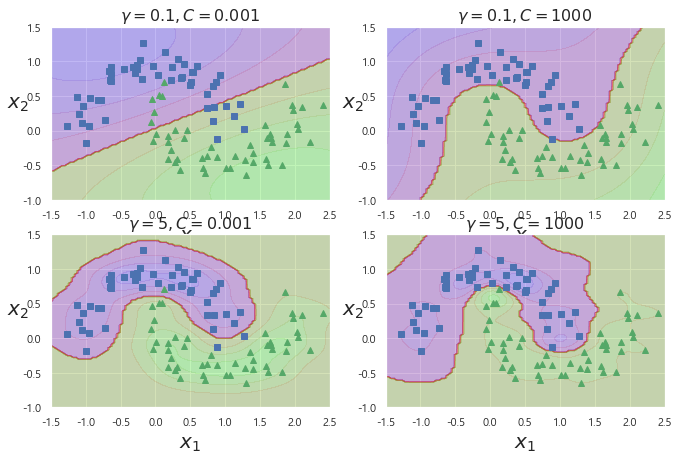

In [14]:
rbf_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))
    ])

rbf_kernel_svm_clf.fit(X, y)

gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

plt.figure(figsize=(11, 7))

for i, svm_clf in enumerate(svm_clfs):
    plt.subplot(221 + i)
    plot_predictions(svm_clf, [-1.5, 2.5, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)

plt.show()

#### Tip : 어떤 커널(kernel)을 사용할까?

> 가장먼저 선형 커널(linear kernel)을 사용해본다. 특히, Train set이 매우 크거나, 특성 수가 많을 경우에 해당되며, Scikit-Learn에서는 `LinearSVC`가 `SVC(kernel='linear')` 보다 훨씬 빠르다. 

>Train set이 크지 않다면, 가우시안 RBF 커널을 시도하는 것이 좋고, 대부분의 경우 이 커널이 잘 맞는다고 한다.

### 5.3 SVM 회귀

SVM은 선형, 비선형 분류 뿐만 아니라 선형, 비선형 회귀(regression)에도 사용할 수 있다. 

SVM을 회귀에 적용하는 방법은 분류와는 반대라고 할 수 있다. 분류에서는 정해진 margin 오류 안에서 두 클래스 간의 폭(너비)가 가능한 최대가 되도록 하는 것이었다. 하지만, 회귀에서는 마진(margin)의 밖이 오류에 해당하며, 마진 안쪽으로 최대한 많은 데이터들이 포함되도록 학습한다.

마진 안쪽으로 Train set이 추가되어도 모델의 예측에는 영향을 주지 않는다.


- LinearSVR을 이용한 선형 SVM 회귀

$$
y = 4 + 3x + \text{noise}
$$

In [15]:
np.random.seed(42)
m = 50
X = 2 * np.random.rand(m, 1)
y = (4 + 3 * X + np.random.randn(m, 1)).ravel()

In [16]:
from sklearn.svm import LinearSVR

svm_reg = LinearSVR(epsilon=1.5, random_state=42)
svm_reg.fit(X, y)

LinearSVR(C=1.0, dual=True, epsilon=1.5, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=42, tol=0.0001, verbose=0)

In [17]:
svm_reg1 = LinearSVR(epsilon=1.5, random_state=42)
svm_reg2 = LinearSVR(epsilon=0.5, random_state=42)
svm_reg1.fit(X, y)
svm_reg2.fit(X, y)

def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    off_margin = (np.abs(y - y_pred) >= svm_reg.epsilon)
    return np.argwhere(off_margin)

svm_reg1.support_ = find_support_vectors(svm_reg1, X, y)
svm_reg2.support_ = find_support_vectors(svm_reg2, X, y)

eps_x1 = 1
eps_y_pred = svm_reg1.predict([[eps_x1]])

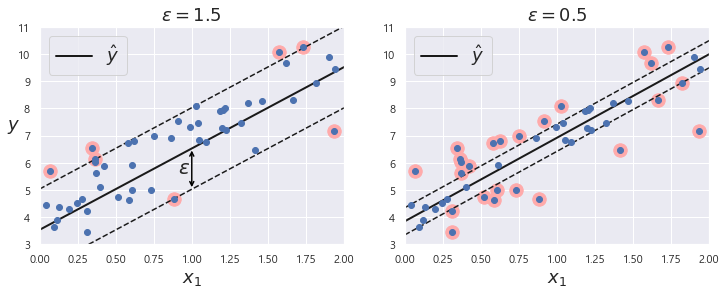

In [18]:
def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors='#FFAAAA')
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)

plt.figure(figsize=(12, 4))
plt.subplot(121)
plot_svm_regression(svm_reg1, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
#plt.plot([eps_x1, eps_x1], [eps_y_pred, eps_y_pred - svm_reg1.epsilon], "k-", linewidth=2)
plt.annotate(
        '', xy=(eps_x1, eps_y_pred), xycoords='data',
        xytext=(eps_x1, eps_y_pred - svm_reg1.epsilon),
        textcoords='data', arrowprops={'arrowstyle': '<->', 'linewidth': 1.5, 'color': 'black'}
    )
plt.text(0.91, 5.6, r"$\epsilon$", fontsize=20)
plt.subplot(122)
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg2.epsilon), fontsize=18)
plt.show()

- SVR을 이용한 비선형 SVM 회귀

$$
y = 0.2 + 0.1x + 0.5 x^{2} + \text{noise}
$$

In [19]:
np.random.seed(42)
m = 100
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()

C:\Users\user\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


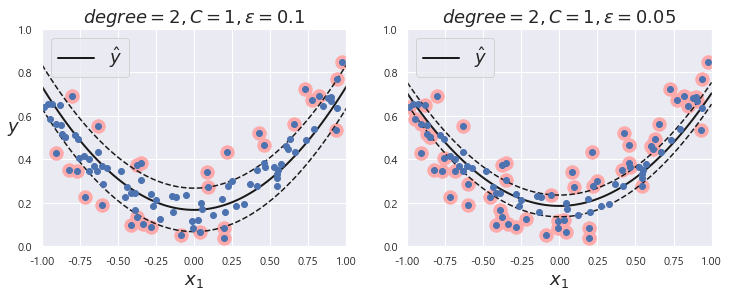

In [20]:
from sklearn.svm import SVR

svm_poly_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1)
svm_poly_reg.fit(X, y)

svm_poly_reg1 = SVR(kernel="poly", degree=2, C=1, epsilon=0.1)
svm_poly_reg2 = SVR(kernel="poly", degree=2, C=1, epsilon=0.05)
svm_poly_reg1.fit(X, y)
svm_poly_reg2.fit(X, y)

plt.figure(figsize=(12, 4))
plt.subplot(121)
plot_svm_regression(svm_poly_reg1, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg1.degree, svm_poly_reg1.C, svm_poly_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
plt.subplot(122)
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg2.degree, svm_poly_reg2.C, svm_poly_reg2.epsilon), fontsize=18)
plt.show()

- SVM을 이상치 탐지에도 사용가능하다.

### 5.4 SVM 이론

##### 5.4.1  결정 함수와 예측

Linear SVM은 두 클래스를 분리하기 위한 선형 결정 함수를 찾는 것이며, 이러한 결정 함수는 다음과 같이 나타낼 수 있다.

$$
d (\mathbf{x}) = \mathbf{w}^{T} \mathbf{x} + b = 0
$$

- $d(x)$는 전체 특성 공간을 두 영역으로 분할한다.
    - $d(x) = \mathbf{w}^{T} \mathbf{x} + b > 0$ → $w_1$
    - $d(x) = \mathbf{w}^{T} \mathbf{x} + b < 0$ → $w_2$
    
#### 커널의 종류

Scikit-Learn의 [`SVC`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) 클래스에서 제공하는 커널의 종류는 다음과 같다. 각 변수에 대한 자세한 내용은 해당 링크를 참고하면 된다. 

- **선형(linear)** : $K(\mathbf{a}, \mathbf{b}) = \mathbf{a}^{T} \cdot \mathbf{b}$
- **다항식(poly)** : $K(\mathbf{a}, \mathbf{b}) = \left( \gamma \mathbf{a}^{T} \cdot  \mathbf{b} + r \right)^{d}$
- **가우시안 RBF(rbf)** : $K(\mathbf{a}, \mathbf{b}) = \text{exp} \left( -\gamma \| \mathbf{a} - \mathbf{b} \|^{2} \right)$
- **시그모이드(sigmoid)** : $K(\mathbf{a}, \mathbf{b}) = \tanh {\left( \gamma \mathbf{a}^{T} \cdot  \mathbf{b} + r \right)}$